<img src="images/logo.png" width="400">

<h1><center>  Data Challenge X-PSG  </center></h1>


In this notebook, i'll try to explain my approach of the X-PSG Data Challenge. Let's look into it step by step. 


# Outline

## <a href="#1.-Load-Data " style="color:#00925B">1.&nbsp;&nbsp;Load Data</a>

## <a href="#2.-Data-Processing " style="color:#00925B">2.&nbsp;&nbsp;Data Processing</a>

- <a href="#2.1.-Get-Players-that-played-more-than-800-min" style="color:#00925B">2.1.&nbsp;&nbsp;Get Players that played more than 800 min</a>

- <a href="#2.2.-Get-Teams-with-Players_ID" style="color:#00925B">2.2.&nbsp;&nbsp;Get Teams with Players_ID</a>

-  <a href="#2.3.-Team-Trick" style="color:#00925B">2.3.&nbsp;&nbsp;Team Trick</a>

## <a href="#3.-Features-Selection" style="color:#00925B">3.&nbsp;&nbsp;Feature Selection</a>

-  <a href="#3.1.-Selection-of-features" style="color:#00925B">3.1.&nbsp;&nbsp;Feature Selection</a>

-  <a href="#3.2.-Extract-feature-vectors" style="color:#00925B">3.2.&nbsp;&nbsp;Extract-feature-vectors</a>

-  <a href="#3.3.-Load-Train-and-Validation-Data" style="color:#00925B">3.3.&nbsp;&nbsp; Load Train and Validation Data</a>

## <a href="#4.-Player-Prediction-Model" style="color:#00925B">4.&nbsp;&nbsp;Player Prediction Model</a>

-  <a href="#4.1.-Random-Forest" style="color:#00925B">4.1.&nbsp;&nbsp;Random Forest</a>
-  <a href="#4.2.-Neural-Nets" style="color:#00925B">4.2.&nbsp;&nbsp;Neural Nets</a>

## <a href="#5.-Predict-Next-Team" style="color:#00925B">5.&nbsp;&nbsp;Predict Next Team</a>
-  <a href="#5.1.-Model-n°1" style="color:#00925B">5.1.&nbsp;&nbsp;Model n°1</a>
-  <a href="#5.2.-Model-n°2" style="color:#00925B">5.2.&nbsp;&nbsp;Model n°2</a>

## <a href="#6.-Predict-Next-Coordinate" style="color:#00925B">6.&nbsp;&nbsp;Predict Next Coordinate</a>

## <a href="#7.-Comparaison-with-or-without-team-trick" style="color:#00925B">7.&nbsp;&nbsp;Bonus : Team Trick</a>


In [1]:
# from jyquickhelper import add_notebook_menu
# add_notebook_menu()

## 0. Packages

In [2]:
# Packages to parse the xml files
from lxml import etree
from lxml import objectify
import xml.etree.ElementTree as et 

# Packages to deal with dataframes, and numpy array and general processing
import os
import random
import numpy as np
import pandas as pd

# Uselful packages
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm, tqdm_notebook


# Keras models and objets
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import sequence, image
from keras.layers.wrappers import Bidirectional
from keras.models import Sequential, Model, load_model
from keras.applications.inception_v3 import InceptionV3
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, \
                         RepeatVector, Concatenate, Activation, Flatten,\
                         Input, BatchNormalization, Dropout, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


## 1. Load Data

First of all we need to parse the data from the xml files at our disposal. To do so, we'll create three dataframe that deals respectively with the general game information, the event occuring during the game, and the qualifier features related to those event. 

To have a general idea the amount of information :
- the game related dataframe is 1 line of 10 features
- the event related dataframe is around 1812 rows of 16 features
- the qualifier related dataframe is around 200 000 rows of 4 features.

Parse XML file to get three dataframe : 
- game_df : info in the game
- even_df : rows on the differents events that occur during the game
- q_df : qualifiers table with information regarding events (several qualifiers can describe the same event)

In [3]:
#%load load_data.py
from load_data import parse_xml_file, event_df_columns, game_df_columns, q_df_columns

Exemple

In [4]:
test_file = r"Exemple de fichier pour base de test - f24-24-2016-853285-eventdetails_test_hackathon_2.xml"
#test_file = r'D:\PSG\French Ligue One 20162017 season - Match Day 1- 19\f24-24-2016-853139-eventdetails.xml'
game_df, event_df, q_df = parse_xml_file(test_file)

In [8]:
q_df.head()

,id_event,id,qualifier_id,value
0,0,,1,
1,0,,213,2.9
2,0,,,
3,0,,107,
4,0,,212,31.7


In [5]:
event_df.head()

,id_game,own_id,id,event_id,type_id,period_id,min,sec,player_id,team_id,outcome,x,y,timestamp,last_modified,version
0,,0,,646,1,2,63,0,0,0,1,0.0,0.0,,,
1,,1,,647,1,2,63,4,0,0,1,0.0,0.0,,,
2,,2,,648,1,2,63,7,0,0,1,0.0,0.0,,,
3,,3,,649,1,2,63,10,1,0,1,0.0,0.0,,,
4,,4,,650,1,2,63,13,0,0,1,0.0,0.0,,,


_________________________

# 2. Data Processing

## 2.1. Get Players that played more than 800 min

Second important thing we need to do is to get the list of player that played at least 800 minutes during the first part of the season. 

To do so we create a dictionnary of the cumulated amount of minutes of each player that played a game during at least one game. Then we keep only players that have a cumulated time above 800. Remark: to be sure that we cover the range of player, we'll threshold at 780 min (it only add 4 player regarding to 800 min so it is not a big deal). The safer, the better.

Get the ID of players that played more than 800 min in the first part of the season

In [75]:
#%load active_players.py

In [76]:
import pickle 
with open('time_per_player.pickle', 'rb') as handle:
    dictionnary_time_per_player = pickle.load(handle)
    
import pickle 
with open('player_names.pickle', 'rb') as handle:
    player_names = pickle.load(handle)

from collections import Counter
c = Counter(dictionnary_time_per_player)
c.most_common(10)

active_player_800 = [player_id for player_id, value in dictionnary_time_per_player.items() if value >= 780]
print('{} active players that played more than 800 minutes'.format(len(active_player_800)))

230 active players that played more than 800 minutes


In [77]:
#len([player_id for player_id, value in dictionnary_time_per_player.items() if value >= 780])

Let's have two complementary dictionnary to map players with their unique ID we'll give them between 0 and 230. This will be necessary to get the ID out of the prediction. 

In [78]:
player_to_idx = {}
for i,j in enumerate(active_player_800):
    player_to_idx[str(j)] = i
#player_to_idx

idx_to_player = {}
for i,j in enumerate(active_player_800):
    idx_to_player[i] = str(j)
#player_to_idx

In [79]:
print(active_player_800[:10])
for player in active_player_800[:5]:
    print('-', player_names.get(player, 'Unknown player'))

['171101', '37832', '168568', '59963', '38816', '44488', '169007', '59957', '54772', '149519']
- Unknown player
- Jérémy Morel
- Corentin Tolisso
- Maxime Gonalons
- Guy NDy Assembe


______________________________________________________

## 2.2. Get Teams with Players_ID

In can be interesting to get the list of players and more specificly active player we might predict in each team. This might be potentially helpful if we choose to predict the team first and then the players for instance.

To do so, we'll look at the qualifier_id 30 that give the squad of players both on the pitch and on the bench. This will give us the player involved during the first part of the season. Remark : we'll only look at games after September, in case the player has been transfered in another club in August for instance, as it happended with M'Bappé two years ago.

In [80]:
folder_games = r'D:\PSG\French Ligue One 20162017 season - Match Day 1- 19'

In [81]:
dic_team = {}
team_name = {}
all_games = sorted(os.listdir(folder_games))

for idx in tqdm_notebook(range(len(all_games))):
    file =  os.path.join(folder_games,all_games[idx])
    game_df,event_df,q_df =  parse_xml_file(file)
    
    if game_df.loc[game_df.index[0],'game_date'][5:7] < '09':
        continue
        
    away_team =  game_df.loc[game_df.index[0],'away_team_name']
    away_id = int(game_df.loc[game_df.index[0],'away_team_id'])
    
    home_team =  game_df.loc[game_df.index[0],'home_team_name']
    home_id = int(game_df.loc[game_df.index[0],'home_team_id'])

    if team_name.get(home_id,'') != '':
        assert team_name[home_id] == home_team
        
    if team_name.get(away_id,'') != '':
        try :
            assert team_name[away_id] == away_team
        except : 
            print(team_name[away_id], away_team)
            
    team_name[home_id] = home_team
    team_name[away_id] = away_team

    q_df = q_df[q_df['qualifier_id']=='30']

    for i in q_df.index[:2]:
        event_id = q_df.loc[i, 'id_event']
        player_list =  q_df.loc[i, 'value'].split(', ')
        team_id = int(event_df[event_df['own_id'] == event_id].team_id)
        dic_team[team_id] = dic_team.get(team_id, []) + player_list


Number of players involved in a Ligue 1 game for each team:

In [82]:
tot = []
for team in dic_team.keys():
    #if team == 146:
    #    print(Counter( dic_team[team]).most_common(10))
    tot += dic_team[team]
    dic_team[team] = set(dic_team[team])
    print(team_name[team],len(list(dic_team[team])))

Nancy 26
Lorient 29
Lille 29
Monaco 24
Marseille 24
Nice 25
Paris Saint-Germain 26
St Etienne 31
Toulouse 28
Bastia 28
Dijon 24
Angers 26
Caen 24
Rennes 30
Nantes 24
Metz 26
Guingamp 25
Montpellier 26
Lyon 27
Bordeaux 28


We'll save lots of small dictionnary like those two, it will be easier for submitting the prediction files (one will just have to load pickle files and use them directly)

In [83]:
with open('team_names.pkl', 'wb') as handle:
    pickle.dump(team_name, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('team_squad.pkl', 'wb') as handle:
    pickle.dump(dic_team, handle, protocol=pickle.HIGHEST_PROTOCOL)

For exemple, we can look at active players that played more than 800 minutes and that we might want to to predict.

In [84]:
print('TEAM :',team_name[149])
for player in list(dic_team[149]):
    if player in active_player_800 :
        print(player, player_names.get(player,'No match'), ' -------->')
    else : 
        print(player, player_names.get(player,'No match'))

TEAM : Paris Saint-Germain
116406 Marcos Aoas Correa  -------->
51090 Thiago Emiliano da Silva  -------->
95715 Lucas Rodrigues Moura da Silva  -------->
93605 Thomas Meunier
80226 Serge Aurier  -------->
54782 Javier Pastore
11527 Thiago Motta  -------->
225897 No match
37971 Blaise Matuidi  -------->
40720 Edinson Cavani  -------->
93127 Jesé Rodríguez Ruiz
120743 Adrien Rabiot  -------->
198523 Jean-Kévin Augustin
52482 Kevin Trapp
129479 Presnel Kimpembe  -------->
46497 Ángel Di María  -------->
9809 Maxwell Scherrer Cabelino Andrade
213199 Remy Descamps
213198 Christopher Nkunku
199672 Nanitamo Jonathan Ikone
212950 Lorenzo Callegari
89068 Layvin Kurzawa  -------->
73494 Grzegorz Krychowiak
18753 Hatem Ben Arfa
84182 Alphonse Areola  -------->
61170 Marco Verratti  -------->


<img src="images/PSG_active_players.jpg" width="600">

Let's define the dictionnary of the active players per team (usually between 9 and 13 per team)

In [85]:
dic_team_active = {}
for team in dic_team.keys():
    l=[]
    for player in list(dic_team[team]):
        if player in active_player_800 :
            l.append(player)
    dic_team_active[team] = l

In [86]:
with open('team_squad_active.pickle', 'wb') as handle:
    pickle.dump(dic_team_active, handle, protocol=pickle.HIGHEST_PROTOCOL)

for team  in dic_team.keys():
    print(team_name[team],'({})'.format(team), len(dic_team_active[team]), 'active players')

Nancy (148) 9 active players
Lorient (694) 11 active players
Lille (429) 11 active players
Monaco (146) 10 active players
Marseille (144) 12 active players
Nice (1395) 12 active players
Paris Saint-Germain (149) 13 active players
St Etienne (152) 12 active players
Toulouse (427) 13 active players
Bastia (139) 13 active players
Dijon (2130) 13 active players
Angers (2128) 11 active players
Caen (1028) 11 active players
Rennes (150) 12 active players
Nantes (430) 11 active players
Metz (145) 11 active players
Guingamp (428) 10 active players
Montpellier (147) 10 active players
Lyon (143) 13 active players
Bordeaux (140) 12 active players


In [87]:
#dic_team, team_name

Let's map as well teams with a unique ID between 0 and 19

In [88]:
list_team = sorted(dic_team.keys())

team_idx = {}
for i,j in enumerate(list_team):
    team_idx[j] = i 
    
for key in team_idx.keys():
    print(key,team_idx[key], team_name[key])

139 0 Bastia
140 1 Bordeaux
143 2 Lyon
144 3 Marseille
145 4 Metz
146 5 Monaco
147 6 Montpellier
148 7 Nancy
149 8 Paris Saint-Germain
150 9 Rennes
152 10 St Etienne
427 11 Toulouse
428 12 Guingamp
429 13 Lille
430 14 Nantes
694 15 Lorient
1028 16 Caen
1395 17 Nice
2128 18 Angers
2130 19 Dijon


_______________________________________

## 2.3. Team Trick

First task, we might want to predict the team playing. 

By looking into the test file (after procedure), we can see that some information has been left out of the cleaning and it concerns the value of qualifier ID related to the composition of team during substitution or change of captain. By looking at qualifier id 7, 30, 53, 194, 281, one can recover the players involved in the game and figure out very quickly which team is playing.

In [89]:
# From a set of player involves during a game, we get the best match of potential team playing
def get_team(set_player):
    best_match, inter = '', 0
    for team in dic_team.keys():
        inter_list = dic_team[team].intersection(set_player)
        if len(inter_list) > inter :
            inter = len(inter_list)
            best_match = team
    return best_match, inter

print(get_team(set('60582, 102747, 15930, 116643, 71403, 178478, 167449, \
                169102, 48847, 19624, 165809, 7446, 198065, 172987, 220160, 192292'.split(', '))))

get_team(set('93619, 100955, 110347, 106263, 44312, 121111, 86158,\
50148, 147577'.split(', ')))

(146, 15)


(2130, 7)

For instance, if we look at the test file, one can find out that it was the game Monaco-Dijon

In [90]:
test_file = r"Exemple de fichier pour base de test - f24-24-2016-853285-eventdetails_test_hackathon_2.xml"

game_df_test, event_df_test, q_df = parse_xml_file(test_file)
q_id_with_players = [7, 30 , 53, 194, 281]
teams= {}

for i in q_id_with_players:
    #if i == 30:
    #    print(q_df[q_df['qualifier_id']==str(i)].id_event.unique())
    df_chunk =  q_df[q_df['qualifier_id']==str(i)] 
    for row in df_chunk.iterrows():
        id_event = row[1]['id_event']
        value = row[1]['value'].split(', ')
        #print(id_event,value)
        id_team = event_df_test[event_df_test['own_id'] ==  id_event].team_id.values[0]
        teams[id_team] = teams.get(id_team,[]) + value
        
for t in teams : 
    teams[t] = set(teams[t])
    team, val = get_team(teams[t])
    if val > 1 :
        print('Team ',t, 'must be ',team)
        print(dic_team[team].intersection(active_player_800))
        print(teams[t].intersection(active_player_800))

    #event_df_test[event_df_test['event_id']=='700']
    #print(q_df[q_df['qualifier_id']==str(i)].id_event.unique(), q_df[q_df['qualifier_id']==str(i)].value.unique())

Team  1 must be  2130
{'111265', '50148', '119679', '98746', '54413', '153014', '13939', '212325', '121111', '93619', '106263', '100955', '147577'}
{'111265', '50148', '54413', '153014', '121111', '93619', '106263', '100955', '147577'}
Team  0 must be  146
{'116643', '165809', '97041', '71403', '102826', '102747', '169102', '60582', '167449', '162654'}
{'116643', '165809', '71403', '102747', '169102', '60582', '167449'}


Hence, we can get, if available, the team playing and more specifically the player's team we are interested in.

In [91]:
def get_team_id(xml_file):
    
    game_df, event_df, q_df = parse_xml_file(xml_file)
    
    q_id_with_players = [7, 30 , 53, 194, 281]
    teams= {}

    for i in q_id_with_players:
        df_chunk =  q_df[q_df['qualifier_id']==str(i)] 
        for row in df_chunk.iterrows():
            id_event = row[1]['id_event']
            value = row[1]['value'].split(', ')
            #print(id_event,value)
            id_team = event_df_test[event_df_test['own_id'] ==  id_event].team_id.values[0]
            teams[id_team] = teams.get(id_team,[]) + value
    
    team_dic = {}
    for t in range(2) : 
        teams[t] = set(teams[str(t)])
        team, val = get_team(teams[t])
        if val > 1 :
            team_dic[str(t)] = team
        #print(team_name[team])
    return team_dic

def player_team_id(xml_file):
    team_playing = get_team_id(test_file)
    
    game_df, event_df, q_df = parse_xml_file(xml_file)
    team_id = event_df[event_df['player_id'] == '1'].team_id.unique()[0]
    return team_playing.get(team_id, 'None')


For instance, here, we can guess it is Dijon (home) - Monaco (away) and that the player of interest if playing at Monaco

In [92]:
test_file = r"Exemple de fichier pour base de test - f24-24-2016-853285-eventdetails_test_hackathon_2.xml"
team_playing = get_team_id(test_file)
is_away = team_playing.get('0', 'None')
is_home = team_playing.get('1', 'None')
print('Home team : ', team_name[is_home], '\nAway team : ', team_name[is_away] )

Home team :  Dijon 
Away team :  Monaco


In [93]:
player_team = player_team_id(test_file)
print(player_team, team_name[player_team])

146 Monaco


The main useful application of this trick is that we can get a restricted list of player that might correspond to the player of interest. Instead of looking at the whole list of 230 players, here we can restrict our prediction to only 9-10 players.

In [94]:
idx_to_filter = [player_to_idx[i] for i in dic_team_active[player_team]]
idx_to_filter

[133, 126, 125, 127, 140, 129, 141, 190, 124, 128]

We will use it, when predicting probability on players, by taking the maximum on the set of corresponding indices only.

______________________________

# 3. Feature Selection

## 3.1. Selection of features

We'll start filtering and selecting some qualifier features that seems inappropriate for the tasks. For instance, features related to the conditions are not available after the cleaning procedure (as they appear only at the before the game). One might still confess that, home team can be more easily guessed by the weather condition. It definitly rains more often at Lille than at Toulouse, maybe.

We'll also removed features related to the referee and the VAR assistance (that was not used 2 years ago). Other features, that I found not relevant were removed as well.

In [21]:
Conditions =  [i for i in range(45, 52)] + [i for i in range(255, 260)]
Referee = [i for i in range(200,210)]+ [54, 226, 227, 228, 229, 246, 247, 248, 299, 303, 344] #Useless
Referee_VAR = [i for i in range(329,345)]
Other = [ 238, 57, 127, 144, 189, 277,299, 302,303,308, 309, 325]

useless_q = sorted(Conditions + Referee + Referee_VAR + Other)
useless_q = [str(idx) for idx in useless_q]
print(len(useless_q), 'unused features')

61 unused features


In [22]:
all_games = os.listdir(folder_games)
file =  os.path.join(folder_games,all_games[0])
_,event_df_all,q_df_all =  parse_xml_file(file)
for idx in tqdm_notebook(range(0,len(all_games))):
    file =  os.path.join(folder_games,all_games[idx])
    _,event_df,q_df_ =  parse_xml_file(file)
    q_df_all = pd.concat([q_df_all, q_df_])
    event_df_all = pd.concat([event_df_all, event_df])
print(q_df_all.shape[0])


1495595


In [23]:
print(len(sorted(q_df_all.qualifier_id.unique())), 'different qualifier features')
qualifier_ids = sorted([idx for idx in q_df_all.qualifier_id.unique() if idx not in useless_q])
print(len(qualifier_ids), 'remaining qualifier features')

230 different qualifier features
202 remaining qualifier features


In [24]:
event_df_all.type_id.unique()

array(['34', '32', '1', '5', '61', '43', '49', '3', '50', '7', '8', '59',
       '52', '45', '56', '44', '4', '15', '10', '13', '12', '11', '74',
       '55', '2', '6', '27', '28', '17', '16', '51', '70', '30', '18',
       '19', '54', '41', '37', '53', '60', '68', '40', '14', '42', '24',
       '57', '58', '65', '20', '25'], dtype=object)

In [25]:
print(len(sorted(event_df_all.type_id.unique())), 'different event features')
event_ids = sorted([idx for idx in event_df_all.type_id.unique()])
print(len(event_ids), 'remaining event features')

50 different event features
50 remaining event features


In [26]:
qualifier_ids = sorted([idx for idx in q_df_all.qualifier_id.unique() if idx not in useless_q])
len(qualifier_ids)

202

In [27]:
with open('qualifier_ids.pickle', 'wb') as handle:
    pickle.dump(qualifier_ids, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('event_ids.pickle', 'wb') as handle:
    pickle.dump(event_ids, handle, protocol=pickle.HIGHEST_PROTOCOL)

Let's create a mapping of the qualifier_ids (between 1 and 320) to fixed indexes between 0 and 202 that will be used to create feature vectors of size 202. Same for event_ids.

In [28]:
q_to_idx = {}
for i,j in enumerate(qualifier_ids):
    q_to_idx[str(j)] = i
    
event_to_idx = {}
for i,j in enumerate(event_ids):
    event_to_idx[str(j)] = i

In [29]:
idx_to_q = {}
for i,j in enumerate(qualifier_ids):
    idx_to_q[i] = int(j)
    
idx_to_event = {}
for i,j in enumerate(event_ids):
    idx_to_event[i] = int(j)

In [30]:
len(qualifier_ids), len(event_ids)

(202, 50)

Now we can create features vectors. We will create two of them :
 - a **team feature vector** basically composed of aggregated occurences of each event/qualifier and the pourcentage of positive outcome.
 - a **player feature vector** composed of the same components but only for 1 targeted player.
We will had to those vectors the home/away component, the average time of the game the events occured and the period (first of second half)

In [31]:
def get_features_vector(df_q, df_event):
    
    ''' Extract the aggregated feature vectors of the team (home or away). 

    This feature vectors basically consists in the aggregation for both team of all different 
    event occuring (related to one team at a time) and the pourcentage of positive outcome for 
    each event '''
    
    df_event['outcome'] = df_event['outcome'].astype(int)
    df = df_q.join(df_event.set_index('own_id')[['outcome', 'team_id','period_id']],on=['id_event'])
    
    #df['outcome'] = df['outcome'].astype(int)
    df_event['min'] = df_event['min'].astype(int)

    
    vec_list = []
    
    for team in range(2):
        
        #Choose the team (either 0 or 1)
        df_chunk = df[df['team_id'] == str(team)]
        #print(str(team))
        df_event_chunk =  df_event[df_event['team_id'] == str(team)]
        
        #Create empty vector
        vec_q = np.zeros(2*len(qualifier_ids)+4)
        vec_e = np.zeros(2*len(event_ids))

        # Get number of occurences
        dic_qualifier = dict(Counter(df_chunk.qualifier_id))
        
        # Get number of occurences
        dic_event = dict(Counter(df_event_chunk.type_id))
        
        # List of keys
        list_keys_q = list(dic_qualifier.keys())
        list_keys_event = list(dic_event.keys())
        #print('Qualifier')
        for feature in list_keys_q:
            
            # Get mapped index of the feature
            mapped = q_to_idx.get(feature,None)
            
            if mapped != None:
                
                #Get the list of outcome of the feature (% of successful event)
                l = list(df_chunk[df_chunk['qualifier_id']==feature].outcome)
                
                # If list isn't empty get the mean, and and to the vector : Nb_Occu, %success
                if l != []:
                    mean = np.round(np.mean(l),3)
                    vec_q[mapped*2+1] = mean
                vec_q[mapped*2] = dic_qualifier[feature]

            else : 
                pass
                #print('Q:',feature)
        
        l = list(df_chunk[df_chunk['qualifier_id']=='56'].value.values)  
        if len(l) == 0 :
            print('EMPTY LIST')
        else :
            c = Counter(l)
            vec_q[-1] = c.get('Right',0) / len(l)
            vec_q[-2] = c.get('Left',0)  / len(l)
            vec_q[-3] = c.get('Center',0)  / len(l)
            vec_q[-4] = c.get('Back',0)  / len(l)
        #56 : Back, Left, Center, Right

        # Same thing with the Event
        for feature in list_keys_event:
            mapped = event_to_idx.get(feature,None)
            
            if mapped != None:
                l = list(df_event_chunk[df_event_chunk['type_id']==feature].outcome)

                if l != []:
                    mean = np.round(np.mean(l),3)
                    vec_e[mapped*2+1] = mean
                vec_e[mapped*2] = dic_event[feature]
            else : 
                pass
                #print('Ev:',feature)

                
        # Add team (home/away), the average minute, and if it is second or first half
        vec = [int(team), int(df_event['min'].mean())/90, (df_event.period_id.unique()[0] == '2')]
        vec = np.concatenate([vec_q, vec_e, vec])
        vec.astype(float)
        vec_list.append(vec)
        
    return vec_list

In [31]:
def get_features_vector_player(df_q, df_event, id_):
    
     ''' Extract the feature vectors of the player of interest. 

    This feature vectors basically consists in the aggregation of all different 
    event the player is involved in, and the pourcentage of positive outcome for 
    each event '''
    
    df_event['outcome'] = df_event['outcome'].astype(int)
    df = df_q.join(df_event.set_index('own_id')[['outcome', 'player_id','period_id']],on=['id_event'])
    
    #df['outcome'] = df['outcome'].astype(int)
    df_event['min'] = df_event['min'].astype(int)
    
    #Choose the player
    df_chunk = df[df['player_id'] == str(id_)]
    df_event_chunk =  df_event[df_event['player_id'] == str(id_)]
    

    #Create empty vector
    vec_q = np.zeros(2*len(qualifier_ids)+4)
    vec_e = np.zeros(2*len(event_ids))

    # Get number of occurences
    dic_qualifier = dict(Counter(df_chunk.qualifier_id))

    # Get number of occurences
    dic_event = dict(Counter(df_event_chunk.type_id))

    # List of keys
    list_keys_q = list(dic_qualifier.keys())
    list_keys_event = list(dic_event.keys())
    #print('Qualifier')
    for feature in list_keys_q:

        # Get mapped index of the feature
        mapped = q_to_idx.get(feature,None)

        if mapped != None:

            #Get the list of outcome of the feature (% of successful event)
            l = list(df_chunk[df_chunk['qualifier_id']==feature].outcome)

            # If list isn't empty get the mean, and and to the vector : Nb_Occu, %success
            if l != []:
                mean = np.round(np.mean(l),3)
                vec_q[mapped*2+1] = mean
            vec_q[mapped*2] = dic_qualifier[feature]

        else : 
            pass
            #print('Q:',feature)

    l = list(df_chunk[df_chunk['qualifier_id']=='56'].value.values)  
    if len(l) == 0 :
        print('EMPTY LIST PLAYER')
        #print(vec_q[-4:], df_event_chunk.shape )
    else :
        c = Counter(l)
        vec_q[-1] = c.get('Right',0) / len(l)
        vec_q[-2] = c.get('Left',0)  / len(l)
        vec_q[-3] = c.get('Center',0)  / len(l)
        vec_q[-4] = c.get('Back',0)  / len(l)
    #56 : Back, Left, Center, Right

    # Same thing with the Event
    for feature in list_keys_event:
        mapped = event_to_idx.get(feature,None)

        if mapped != None:
            l = list(df_event_chunk[df_event_chunk['type_id']==feature].outcome)

            if l != []:
                mean = np.round(np.mean(l),3)
                vec_e[mapped*2+1] = mean
            vec_e[mapped*2] = dic_event[feature]
        else : 
            pass
            #print('Ev:',feature)
    # Add team (home/away), the average minute, and if it is second or first half
    vec = [int(df_event_chunk.team_id.unique()[0]),int(df_event['min'].mean())/90, int(df_event.period_id.unique()[0] == '2')]
    vec = np.concatenate([vec_q, vec_e, vec])
    vec.astype(float)
        
    return vec

Now we're going to create a function that will generate all the possible 15 min chunks per active player in one game. To do so we will iterate on each minutes (i found not very relevant to iterate for every event, the features vectors would be too close, maybe identical, from each other), iterate on the active players that played during the game, select a 15 min chunk and anonymize all player but the active player we're are targeting. We will do this for both team. Everytime we will extract a team vector as well as a player vector and concatenate them into one vector.

In [32]:
def select_15min_chunk(file,itermax=10, predict='team'):
    game_df, event_df, q_df = parse_xml_file(file)
    home_team_id, away_team_id = game_df['home_team_id'][0], game_df['away_team_id'][0]
    #print('ID',home_team_id, away_team_id)
    event_df['team_id'] = event_df['team_id'].map({home_team_id: '1', away_team_id:'0'})
    event_df['min']= event_df['min'].astype(int)
    event_df['x']= event_df['x'].astype(float)
    event_df['y']= event_df['y'].astype(float)
    event_df['period_id']= event_df['period_id'].astype(int)

    for it in range(1,31):
        for half_time in range(2):
            #half_time = np.random.random(1)
            if half_time == 0 : 
                 t = it
            else :
                 t = it+45
            df_chunk = event_df[event_df['period_id'] == (int(half_time>0.5)+1)]
            df_chunk = df_chunk[df_chunk['min'].between(t,t+14)]
            own_id_max = df_chunk.own_id.values[-1]
            own_id_min = df_chunk.own_id.values[0]

            q_chunk = q_df[q_df['id_event'].between(own_id_min, own_id_max)]
            
            if predict == 'team':
                vec1, vec2 = get_features_vector(q_chunk, df_chunk)
                yield vec1, away_team_id
                yield vec2, home_team_id
            if predict == 'player':
                #print('PLAYER')
                available_player = list(df_chunk.player_id.unique())
                vec = get_features_vector(q_chunk, df_chunk)
                for ind,team in enumerate([away_team_id, home_team_id]):
                    for player in dic_team_active[int(team)]:
                        if player in available_player:
                            #print(player)
                            #print(q_chunk.team_id.values)
                            if df_chunk[df_chunk['player_id'] == str(player)].shape[0]==1:
                                #print( df_chunk[df_chunk['player_id'] == str(player)])
                                #print('empty')
                                continue
                            vec_player = get_features_vector_player(q_chunk, df_chunk,player)
                            output = np.zeros(len(active_player_800))
                            output[player_to_idx[player]] = 1
                            yield np.concatenate([vec[ind],vec_player]), output
    #print('file finished')

In [272]:
test_file = r'D:\PSG\French Ligue One 20162017 season - Match Day 1- 19\f24-24-2016-853139-eventdetails.xml'
a,b = next(select_15min_chunk(test_file, predict='player'))
print(a.shape,b.shape)
#a[-104-3:-100-3]

_______________________________

## 3.2. Extract feature vectors

We re going to exact the vectors once and for all, alonside the outcome expected player.

In [34]:
# Extract Vectors

#create folder where we will extract vectors
if not os.path.exists('D:/PSG/feature_vectors'):
    os.mkdir('D:/PSG/feature_vectors')
    
if not os.path.exists('D:/PSG/label_vectors'):
    os.mkdir('D:/PSG/label_vectors')
    
# For all games
for file in tqdm_notebook(all_games):
    if os.path.exists(os.path.join('D:/PSG/feature_vectors',file[:-3]+'npy')):
        continue
    file_path =  os.path.join(folder_games,file)
    #print(file)
    l_features = []
    l_labels = []
    # Iterate on all pairs (15 min vector of team, one seleted player)
    for vec,label in select_15min_chunk(file_path, predict='player'):
        l_features.append(vec[np.newaxis,:])
        l_labels.append(label[np.newaxis,:])
    np.save(os.path.join('D:/PSG/feature_vectors',file[:-3]+'npy'), np.concatenate(l_features,axis=0))
    np.save(os.path.join('D:/PSG/label_vectors',file[:-3]+'npy'),  np.concatenate(l_labels,axis=0))
    print('File saved at ', os.path.join('D:/PSG/feature_vectors',file[:-3]+'npy'))

## Seperate between Train and Validation Data 

Let's split all games between a train and a validation set. To do so, we will first map all games to the related matchday and then select a few number of matchday to become the validation set of games.

In [154]:
all_games = os.listdir(folder_games)
matchday_dic = {}
for idx in tqdm_notebook(range(0,len(all_games))):
    file =  os.path.join(folder_games,all_games[idx])
    game_df,_,_ =  parse_xml_file(file)
    matchday_dic[all_games[idx]] = int(game_df.matchday)

In [155]:
matchday_dic.values()

dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19])

Here, we choose 4 matchdays (around 40 games) across the first half of the season. I started putting aside the last 4 machdays but i found it more relevant and less biaised to choose some matchdays at different moment within the first half of the season. (Especially because some players were missing for the last 4 matchdays and the repartition was better with four non-consecutive matchdays accross the season).

In [156]:
train_data_matchday = [1,2,3,5,6,7,9,10,11,13,14,15,17,18,19]
valid_data_matchday = [4,8,12,16]

print(len(train_data_matchday), len(valid_data_matchday), 'Valid Ratio :',len(valid_data_matchday)/19)

15 4 Valid Ratio : 0.21052631578947367


______________________________________

## 3.3. Load Train and Validation Data

Once we extracted all feature vectors for each game, we can directly and easily split them into a trainig and a validation set.

In [38]:
validation_vectors = []
validation_labels = []
train_vectors = []
train_labels = []

for game in tqdm_notebook(all_games):
    feature = np.load(os.path.join('D:/PSG/feature_vectors',game[:-3]+'npy'))
    label = np.load(os.path.join('D:/PSG/label_vectors',game[:-3]+'npy'))
    
    if matchday_dic[game] in valid_data_matchday :
        validation_vectors.append(feature)
        validation_labels.append(label)
    else : 
        train_vectors.append(feature)
        train_labels.append(label)    

We concatenate the lists into big numpy arrays

In [39]:
validation_vectors = np.concatenate(validation_vectors, axis=0)
validation_labels = np.concatenate(validation_labels, axis=0)
train_vectors = np.concatenate(train_vectors, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

# 4. Player Prediction Model

Let's get some random order between our training data to avoid having very similar examplar in a row.

In [40]:
print('Shape of training data :',train_vectors.shape)
indices = [i for i in range(train_vectors.shape[0])]
random.shuffle(indices)

Shape of training data : (150821, 1022)


## 4.1. Random Forest

Before considering any neural network architecture, let's look at some ML alogothms that might be relevant for the task.
Let's start with Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, max_depth=40, random_state=0, n_jobs=7, min_samples_leaf=20, max_features=80)#, oob_score=True)
rf.fit(train_vectors[indices],  train_labels[indices].argmax(axis=1).astype(str))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features=100, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=7,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [42]:
with open('random_forest_classifier.pickle', 'wb') as handle:
    pickle.dump(rf, handle, protocol=pickle.HIGHEST_PROTOCOL)

One can check the accuracy score for the training and testing part. One can notice as well that the model is largely overfiting but 12% on the test set for 230 classes is quite good in reality !

In [51]:
#score = rf.score(train_vectors, train_labels.argmax(axis=1).astype(str))
#print('Accuracy on train data :',score)

score = rf.score(validation_vectors, validation_labels.argmax(axis=1).astype(str))
print('Accuracy on test data :',score)

Accuracy on test data : 0.11677615452495342


The asset of random forest method is that it gives an importance score on all features to see which are more relevant for the prediction

In [246]:
importances = rf.feature_importances_
indices_rf = np.argsort(importances)[::-1]
for f in range(15):#train_vectors.shape[1]):
    if indices_rf[f] // 511 == 0 :
        if indices_rf[f] < 404 :
            print("%d. Team Qualifier feature %d (%f)" % (f + 1, idx_to_q[indices_rf[f]//2], importances[indices_rf[f]]))
        elif indices_rf[f] < 408 :
            print("%d. Team Qualifier feature %d (%f)" % (f + 1, 56, importances[indices_rf[f]]))
        elif indices_rf[f] <= 507 :
            print("%d. Team Event feature %d (%f)" % (f + 1, idx_to_event[indices_rf[f]//2], importances[indices_rf[f]]))
        else :
            print("%d. Team feature %d (%f)" % (f + 1, indices_rf[f], importances[indices_rf[f]]))
    else :
        if indices_rf[f]-511 < 404 :
              print("%d. Player feature %d (%f)" % (f + 1, idx_to_q[(indices_rf[f]-511)//2], importances[indices_rf[f]]))
        elif indices_rf[f]-511 < 408 :
            print("%d. Player Qualifier feature %d (%f)" % (f + 1, 56, importances[indices_rf[f]]))
        elif indices_rf[f]-511 <= 507 :
            print("%d. Player feature %d (%f)" % (f + 1, idx_to_event[(indices_rf[f]-511)//2], importances[indices_rf[f]])) 
        else :
            print("%d. Player feature %d (%f)" % (f + 1, indices_rf[f]-511, importances[indices_rf[f]]))

1. Player Qualifier feature 56 (0.013459)
2. Player Qualifier feature 56 (0.013381)
3. Player Qualifier feature 56 (0.013149)
4. Team Qualifier feature 56 (0.011794)
5. Team Qualifier feature 56 (0.011340)
6. Player Qualifier feature 56 (0.010506)
7. Team Qualifier feature 56 (0.009953)
8. Team Qualifier feature 56 (0.009751)
9. Player feature 509 (0.008631)
10. Team feature 509 (0.008533)
11. Team Qualifier feature 56 (0.007864)
12. Team Qualifier feature 3 (0.007017)
13. Player feature 107 (0.006741)
14. Team Qualifier feature 157 (0.006728)
15. Player feature 56 (0.006691)


Hence, one can notice that the positition of the player (Player Qualifier 56 - Right, Left, Center and Back) is the most important feature, as well as the general orientation of the team (Team Qualifier 56 - Right, Left, Center and Back). The fact that the team plays at home or away (509) as well as the number of head pass (Qualifier 3) are also relevant. And so on...

An other cool feedback we can get is to look at the confusion matrix, to see which player are well predicted for instance but also to look at the misclassified player and confusion between them.

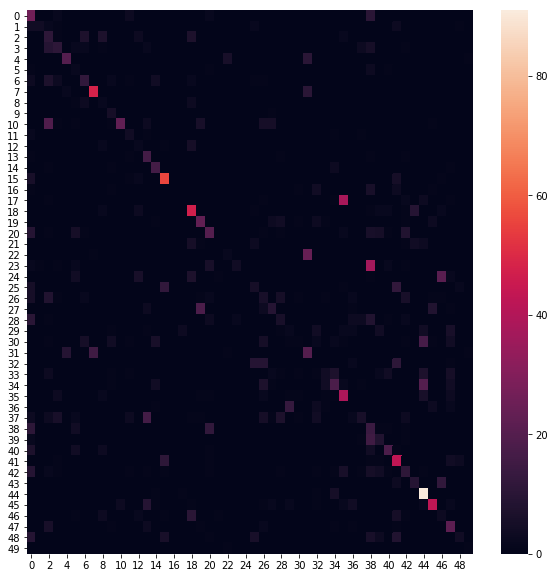

In [258]:
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
import seaborn as sns
#pred = rf.predict(validation_vectors)
cm = confusion_matrix(validation_labels.argmax(axis=1).astype(str), pred, labels = [str(i) for i in range(230)])
ax = sns.heatmap(cm[:50,:50])

In [260]:
tot =  validation_labels.sum(axis=0)
for i in range(230):
    #print(player_names.get(str(idx_to_player[i]),'No Match'),cm[i,i]/tot[i])
    for j in range(230):
        if i==j :
            continue
        else :
            if cm[j,i]>50 or cm[j,i]>50:
                print(player_names.get(str(idx_to_player[i]),'No Match'), '-->', player_names.get(str(idx_to_player[j]),'No Match'))

Yoan Cardinale --> Vincent Enyeama
Hiroki Sakai --> Steven Moreira
Thiago Motta --> Marco Verratti
Vincent Le Goff --> Yoann Andreu
Dante Bonfim Costa Santos --> Malang Sarr


Hence, one can see that the most confused pairs of player are player that look alike and that have very closed profile (a priori). For instance Verratti and Motta plays more or less at the same position in the same team and are player that passes a lot for instance.

One can see that Dante and Sarr are also confused but it seems coherent as they are the two center back of Nice's team ! Similarly, Yohan Cardinale and Enyemama are both Goalkeepers !

<img src="images/Verratti_Motta.jpg" width="400">


In [261]:
tot =  validation_labels.sum(axis=0)
for i in range(20):
    print(player_names.get(str(idx_to_player[i]),'No Match'),cm[i,i]/tot[i])

No Match 0.1087866108786611
Jérémy Morel 0.016666666666666666
Corentin Tolisso 0.0763888888888889
Maxime Gonalons 0.06432748538011696
Guy NDy Assembe 0.1111111111111111
Mapou Yanga-Mbiwa 0.03333333333333333
Sergi Darder 0.09230769230769231
Anthony Lopes 0.20253164556962025
Rafael Pereira da Silva 0.03333333333333333
Maxwel Cornet 0.05102040816326531
Nabil Fekir 0.12777777777777777
Youssef Aït Bennasser 0.02857142857142857
Joffrey Cuffaut 0.016666666666666666
Benoit Pedretti 0.08888888888888889
Alexandre Lacazette 0.08888888888888889
Tobias Badila 0.3111111111111111
Loïc Puyo 0.0
Vincent Pajot 0.0
Youssouf Sabaly 0.19583333333333333
Malcom Filipe Silva de Oliveira 0.13690476190476192


In [268]:
from sklearn.metrics import f1_score
F1 =  f1_score(validation_labels.argmax(axis=1).astype(str), pred, labels = [str(i) for i in range(230)], average=None) 
f1_sorted = np.argsort(F1)[::-1]

for i in f1_sorted[:10]:
    print(player_names.get(str(idx_to_player[i]),'No Match'),F1[i])

Ángel Di María 0.3959731543624161
Yoan Cardinale 0.3926940639269407
Marco Verratti 0.3855421686746988
Layvin Kurzawa 0.34823529411764703
Alphonse Areola 0.3419354838709678
Lucas Pedro Alves de Lima 0.3089700996677741
Steve Mounie 0.3079526226734348
Ricardo Domingos Barbosa Pereira 0.3039014373716633
François Moubandje 0.296
Tobias Badila 0.2955145118733509


The algortihm struggles to find some players (here we have 0 accuracy on those specific ones)

In [270]:
for i in f1_sorted[-10:]:
    print(player_names.get(str(idx_to_player[i]),'No Match'),F1[i])

Tomas Hubocan 0.0
Issiaga Sylla 0.0
Pierrick Capelle 0.0
Marko Basa 0.0
Gaël Danic 0.0
Kévin Monnet-Paquet 0.0
Moustapha Diallo 0.0
Léo Lacroix 0.0
Yann Bodiger 0.0
Ramy Bensebaini 0.0


## 4.2. Neural Nets

An other way to predict the players would be to build a deep neural network.
To do so, I tried to build a 2-tower neural nets, that deals with the team feature vectors separatly from the player one, at first, and then concatenate the two, followed by a simple dense layer. I didn't have a lot a time to work on the architecture, this would be a lead of improvement to explore.

In [292]:
callbacks = []
callbacks.append(
    ModelCheckpoint(os.path.join('D:/PSG/', 'team_prediction.h5'),
                    monitor='val_loss', verbose=1,
                    save_best_only=True, save_weights_only=True,
                    mode='auto', period=1))

In [288]:
x_player = Input(shape=(511, ))
y_player = BatchNormalization(name='batch_normalization_1')(x_player)
y_player = Dense(20,  activation='sigmoid')(y_player)
y_player = Dropout(0.5)(y_player)
player_tower = Model(inputs=x_player, outputs=y_player)

x_player_pps = Input(shape=(4, ))
player_tower_pps = Model(inputs=x_player_pps, outputs=x_player_pps)


x_team = Input(shape=(511, ))
y_team = BatchNormalization(name='batch_normalization_2')(x_team)
y_team = Dense(10,  activation='sigmoid')(y_team)
y_team = Dropout(0.5)(y_team)
team_tower = Model(inputs=x_team, outputs=y_team)

x_team_pps = Input(shape=(4, ))
team_tower_pps = Model(inputs=x_team_pps, outputs=x_team_pps)

merged = concatenate([team_tower.output,player_tower.output, team_tower_pps.output, player_tower_pps.output], axis=1, name ='merge_1')
merged = Dense(230, activation='sigmoid')(merged)

final_model = Model([team_tower.input,player_tower.input, team_tower_pps.input, player_tower_pps.input], merged)
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 511)          0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 511)          0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 511)          2044        input_19[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 511)          2044        input_17[0][0]                   
__________________________________________________________________________________________________
dense_17 (

In [281]:
final_model.fit([train_vectors[indices,:511], train_vectors[indices,511:], train_vectors[indices,404:408],
                 train_vectors[indices,915:919]],
          train_labels[indices], 
          batch_size=128,
          epochs= 100, 
          verbose=2, 
          validation_data = ([validation_vectors[:,:511],validation_vectors[:,511:],  validation_vectors[:,404:408],
                 validation_vectors[:,915:919]], validation_labels), 
          callbacks=callbacks)

```- 17s - loss: 3.2729 - acc: 0.1918 - val_loss: 3.8729 - val_acc: 0.1222```

A very simple neural nets with two Dense layers. To explore as well.

In [280]:
x = Input(shape=(1022, ))
y = BatchNormalization(name='batch_normalization_1')(x)
#y = Dropout(0.5)(x)
y = Dense(50,  activation='sigmoid')(y)
y = Dropout(0.8)(y)
y = Dense(230, activation='sigmoid')(y)
final_model = Model(inputs=x, outputs = y)
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
final_model.summary()

final_model.fit([train_vectors[indices]],
          train_labels[indices], 
          batch_size=128,
          epochs= 100, 
          verbose=2, 
          validation_data = (validation_vectors, validation_labels), 
          callbacks=callbacks)

```- 10s - loss: 3.9816 - acc: 0.0748 - val_loss: 3.9198 - val_acc: 0.1060```

# 5. Predict Next Team

The second task is to predict the next event that will occur avec the 15 min chunk. By next event, I mean will need to predict the team concerned (0 away / 1 home) and the position (x,y) of this event. I choose, for sake of simplicity, to do those two tasks seperatly. Let's start with the next team prediction.

## 5.1. Model n°1

First attempt, I build a batch generator that aims at selecting the 10 last events and to build a vector of size (10,4) that provides information on the team, teh position x, y and the type of event id. 

In [321]:
def batch_generator(mode='Train', batch_size = 64):
    
    all_games = os.listdir(folder_games)
    idx = 0
    batch_input = np.zeros((batch_size, 10, 4))

    batch_output = np.zeros((batch_size))
    a = 0
    if mode=='Train' : 
        def update_idx(idx):
            return (idx+1)%int((len(all_games)*0.8))
    if mode=='Val' : 
        def update_idx(idx):
            return (idx+1)%int((len(all_games)*0.2)) + int((len(all_games)*0.8)) 
    while True : 
        file =  os.path.join(folder_games,all_games[idx])
        idx = update_idx(idx)
        game_df, event_df, q_df = parse_xml_file(file)
        home_team_id, away_team_id = game_df['home_team_id'][0], game_df['away_team_id'][0]

        event_df['team_id'] = event_df['team_id'].map({home_team_id: '1', away_team_id:'0'})
        event_df['min']= event_df['min'].astype(int)
        event_df['x']= event_df['x'].astype(float)
        event_df['y']= event_df['y'].astype(float)
        maxx = event_df['x'].max()
        maxy = event_df['y'].max()
        event_df['period_id']= event_df['period_id'].astype(int)
        event_df = event_df[event_df['min'].between(2,90)]
        
        chunk = [t for t in range(1,event_df.shape[0]-20, 10)]
        
        for t in chunk : 
 
            df_chunk = event_df.loc[event_df.index[t:t+10]]
            output = int(event_df.loc[event_df.index[t+10],'team_id'])
        
            df_chunk = df_chunk[['team_id','x', 'y','type_id']]

            batch_input[a,:,:] = np.array(df_chunk)
            batch_input[a,:,1] /= maxx
            batch_input[a,:,2] /= maxy
            batch_output[a] = output

            a+=1

            if a % batch_size == 0:
                yield [batch_input[:,:,3:].reshape((batch_size,10)),batch_input[:,:,:3]] , batch_output

                batch_input = np.zeros((batch_size, 10, 4))
                batch_output = np.zeros((batch_size))
                a=0

The first model is very basic. Two tower. One for the event id part that aims at creating an embeddings of events out of the sequences of events. One can think about words in a sentence for instance. Thise is a very similar idea. I hope the embedding will capture interesting relationship between events. Then I'll concatente the embedded events alongside the sequences of (x,y,team) and put it into an LSTM layer followed by two dense layers. 

This gives approximetly 80% of accuracy on a set of events occurung during 20% of the unseen games.

In [324]:
callbacks = []
callbacks.append(
    ModelCheckpoint(os.path.join('D:/PSG/', 'team_prediction.h5'),
                    monitor='val_loss', verbose=1,
                    save_best_only=True, save_weights_only=True,
                    mode='auto', period=1))

In [329]:
coord_in = Input(shape=(10,3,),name='input_2')
#x = BatchNormalization(name='batch_normalization_1')(coord_in)
#x = Dense(10, activation='relu',name='dense_1')(x)           
coord = Model(inputs=coord_in, outputs=coord_in)
coord.summary()

# Caption Encoder
caption_in = Input(shape=(10, ), name='input_1')
y = Embedding(77, 10, input_length=10, name ='embedding_1')(caption_in)
#y = LSTM(10,return_sequences=True)(y)
#y = BatchNormalization(name='batch_normalization_95')(y)

type_event = Model(inputs=caption_in, outputs=y)
type_event.summary()

merged = concatenate([type_event.output, coord.output], axis=2, name ='merge_1')
merged = LSTM(10)(merged)
#merged = Dropout(0.3)(merged)
merged = Dense(5, activation='sigmoid')(merged)
#merged = Dropout(0.2)(merged)
merged = Dense(1, activation='sigmoid')(merged)

final_model = Model([type_event.input,coord.input], merged)
final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10, 3)             0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 10)            770       
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLaye

In [279]:
final_model.optimizer = Adam(lr=1e-4)

final_model.fit_generator(
            generator=batch_generator('Train', 32),
            steps_per_epoch=400,
            epochs=100,
            verbose=2,
            callbacks=callbacks,
            validation_data=batch_generator('Val'),
            validation_steps = 68)

```- 33s - loss: 0.4377 - acc: 0.7993 - val_loss: 0.4645 - val_acc: 0.7911```

Another try, without the embedding tower.

In [380]:
def batch_generator(mode='Train', batch_size = 64):
    
    all_games = os.listdir(folder_games)
    idx = 0
    batch_input = np.zeros((batch_size, 10, 80))

    batch_output = np.zeros((batch_size,1))
    a = 0
    if mode=='Train' : 
        def update_idx(idx):
            return (idx+1)%int((len(all_games)*0.8))
    if mode=='Val' : 
        def update_idx(idx):
            return (idx+1)%int((len(all_games)*0.2)) + int((len(all_games)*0.8)) 
    while True : 
        file =  os.path.join(folder_games,all_games[idx])
        idx = update_idx(idx)
        game_df, event_df, q_df = parse_xml_file(file)
        home_team_id, away_team_id = game_df['home_team_id'][0], game_df['away_team_id'][0]

        event_df['team_id'] = event_df['team_id'].map({home_team_id: '1', away_team_id:'0'})
        event_df['min']= event_df['min'].astype(int)
        event_df['x']= event_df['x'].astype(float)
        event_df['y']= event_df['y'].astype(float)
        maxx = event_df['x'].max()
        maxy = event_df['y'].max()
        event_df['period_id']= event_df['period_id'].astype(int)
        event_df = event_df[event_df['min'].between(2,90)]
        
        chunk = [t for t in range(1,event_df.shape[0]-30, 10)]
        
        for t in chunk : 
 
            df_chunk = event_df.loc[event_df.index[t:t+10]]
            output = int(event_df.loc[event_df.index[t+10],'team_id'])
        
            df_chunk = df_chunk[['team_id','x', 'y','type_id']]

            batch_input[a,:,:3] =  df_chunk[['team_id','x', 'y']]
            batch_input[a,:,1] /= maxx
            batch_input[a,:,2] /= maxy
            
            input_ = np.zeros((10,77))
            for i,val in enumerate(df_chunk.type_id.values) :
                input_[i,int(val)] = 1

            batch_input[a,:,3:] = input_
            batch_output[a,0] = output

            a+=1

            if a % batch_size == 0:
                #print('yiel', batch_input.shape,batch_output.shape )
                yield batch_input, batch_output

                batch_input = np.zeros((batch_size, 10, 80))
                batch_output = np.zeros((batch_size,1))
                a=0

In [381]:
next(batch_generator(mode='Train', batch_size = 64))[0].shape

(64, 10, 80)

In [278]:
x = Input(shape=(10,80,),name='input_1')
y = LSTM(20)(x)
merged = Dropout(0.3)(merged)
merged = Dense(5, activation='sigmoid')(y)
merged = Dropout(0.2)(merged)
y = Dense(1, activation='sigmoid')(y)

final_model = Model(inputs=x, outputs=y)
final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

final_model.summary()

final_model.fit_generator(
            generator=batch_generator('Train', 128),
            steps_per_epoch=100,
            epochs=100,
            verbose=2,
            callbacks=callbacks,
            validation_data=batch_generator('Val'),
            validation_steps = 68)

```- 42s - loss: 0.4125 - acc: 0.8156 - val_loss: 0.4489 - val_acc: 0.7971```

## 5.2. Model n°2

The second model, that aim at combining info on the 10 last events as well as a feature vectors of both team during the 15 last minutes. First of all, we re gonna extract a feature vector from the last (approximatly) 15 last minutes with number of occurences and corresponding ratio of positive outcome associated to an event.

In [495]:
def get_array_file(file):
    
    batch_input = []
    batch_vec = []
    batch_output = []
    

    game_df, event_df, q_df = parse_xml_file(file)
    event_df['outcome'] = event_df['outcome'].astype(int)
    home_team_id, away_team_id = game_df['home_team_id'][0], game_df['away_team_id'][0]
    #print('ID',home_team_id, away_team_id)
    event_df['team_id'] = event_df['team_id'].map({home_team_id: '1', away_team_id:'0'})
    event_df['min']= event_df['min'].astype(int)
    event_df['x']= event_df['x'].astype(float)
    event_df['y']= event_df['y'].astype(float)
    event_df['period_id']= event_df['period_id'].astype(int)

    maxx = event_df['x'].max()
    maxy = event_df['y'].max()

    event_df = event_df[event_df['min'].between(1,90)]

    chunk = [t for t in range(1,event_df.shape[0]-310, 5)]

    for t in chunk : 

        # Select the 300 events before the 10 anonymised event
        past_df = event_df.loc[event_df.index[t:t+300]]
        # Select the 10 last ananumised event
        df_chunk = event_df.loc[event_df.index[t+300:t+310]]
        # Get output
        output = int(event_df.loc[event_df.index[t+310],'team_id'])

        # We're gonna collect the two vectors of the past events aggregated by team 
        vec = []
        for team in range(2) :
            # Select the concerned team
            df_event_chunk = past_df[past_df['team_id']==str(team)]
            #print(past_df.shape,df_event_chunk.shape, past_df.team_id.unique())
            #Get occurances of each event type
            dic_event = dict(Counter(df_event_chunk.type_id))
            #print(dic_event)
            # List of keys
            list_keys_event = list(dic_event.keys())
            vec_e = np.zeros(50*2)

            for feature in list_keys_event:
                mapped = event_to_idx.get(feature,None)
                if mapped != None:
                    l = list(df_event_chunk[df_event_chunk['type_id']==feature].outcome)

                    if l != []:
                        mean = np.round(np.mean(l),3)
                        vec_e[mapped*2+1] = mean
                        #print(mean)
                    vec_e[mapped*2] = dic_event[feature]
                else : 
                    pass
            vec.append(vec_e)
        # Vec of event with outcome ratio
        vec = np.concatenate(vec, axis=0)

        batch_vec.append(vec[np.newaxis,:])
        
        df_chunk = df_chunk[['team_id','x', 'y','type_id']]
        batch_input_vec = np.array(df_chunk)
        batch_input_vec[:,1] /= maxx
        batch_input_vec[:,2] /= maxy
        batch_input.append(batch_input_vec[np.newaxis,:,:])
        batch_output.append(output)
        
    return np.concatenate(batch_vec, axis=0), np.concatenate(batch_input, axis=0), np.array(batch_output)

To accelerate the training, we 're gonna ectracte feature vectors for all games once and for all.

In [277]:
for file in tqdm_notebook(all_games):
    if os.path.exists(os.path.join('D:/PSG/batch',file[:-4]+'_vec.npy')):
        continue
    file_path =  os.path.join(folder_games,file)
    # Iterate on all pairs (15 min vector of team, one seleted player)
    vec, input_, output = get_array_file(file_path)
    np.save(os.path.join('D:/PSG/batch',file[:-4]+'_vec.npy'),vec)
    np.save(os.path.join('D:/PSG/batch',file[:-4]+'_input.npy'), input_)
    np.save(os.path.join('D:/PSG/batch',file[:-4]+'_output.npy'), output)
    print('File saved at ', os.path.join('D:/PSG/batch',file[:-3]+'npy'))

In [537]:
validation_vectors = []
validation_input = []
validation_labels = []
train_vectors = []
train_input = []
train_labels = []

for game in tqdm_notebook(all_games):
    if not os.path.exists(os.path.join('D:/PSG/batch',game[:-4]+'_vec.npy')):
        continue
    vec = np.load(os.path.join('D:/PSG/batch',game[:-4]+'_vec.npy'))
    input_ = np.load(os.path.join('D:/PSG/batch',game[:-4]+'_input.npy'))
    label = np.load(os.path.join('D:/PSG/batch',game[:-4]+'_output.npy'))

    if matchday_dic[game] in valid_data_matchday :
        validation_vectors.append(vec)
        validation_input.append(input_)
        validation_labels.append(label)
    else : 
        train_vectors.append(vec)
        train_input.append(input_)
        train_labels.append(label)    

In [538]:
validation_vectors = np.concatenate(validation_vectors, axis=0)
validation_input = np.concatenate(validation_input, axis=0)
validation_labels = np.concatenate(validation_labels, axis=0)

train_vectors = np.concatenate(train_vectors, axis=0)
train_input = np.concatenate(train_input, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

In [539]:
coord_in = Input(shape=(10,3,),name='input_2')       
coord = Model(inputs=coord_in, outputs=coord_in)
coord.summary()

# Caption Encoder
caption_in = Input(shape=(10, ), name='input_1')
y = Embedding(77, 10, input_length=10, name ='embedding_1')(caption_in)
type_event = Model(inputs=caption_in, outputs=y)
type_event.summary()

vec_in = Input(shape=(200, ), name='input_3')
vec_model = Model(inputs=vec_in, outputs=vec_in)


merged = concatenate([type_event.output, coord.output, ], axis=2, name ='merge_1')
merged = LSTM(20)(merged)
merged = concatenate([merged, vec_model.output ], axis=1, name ='merge_2')
#merged = Dropout(0.3)(merged)
merged = Dense(5, activation='sigmoid')(merged)
#merged = Dropout(0.2)(merged)
merged = Dense(1, activation='sigmoid')(merged)

final_model = Model([type_event.input,coord.input, vec_model.output], merged)
final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10, 3)             0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 10)            770       
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLaye

In [276]:
final_model.optimizer = Adam(lr=1e-4)
final_model.fit(
            [train_input[:,:,3],train_input[:,:,:3],train_vectors],
            train_labels,
            epochs=25,
            verbose=2,
            batch_size=16,
            callbacks=callbacks,
            validation_data=([validation_input[:,:,3],validation_input[:,:,:3], validation_vectors], validation_labels))

 ```85s - loss: 0.4167 - acc: 0.8126 - val_loss: 0.4435 - val_acc: 0.8061```

In [547]:
Counter(train_labels)

Counter({0: 20338, 1: 21097})

# 6. Predict Next Coordinate

Last model, the one that will predict the next (x,y) coordinate. Unfortunetly, I didn't get much time to work deeper on this one. It looks like the previous model for the prediction of the next team. Whereas here, we gonna change the metric with MSE and use linear or relu activations instead of sigmoids.

In [72]:
 def get_array_file(file):
    
    batch_input = []
    batch_output = []

    game_df, event_df, q_df = parse_xml_file(file)
    event_df['outcome'] = event_df['outcome'].astype(int)
    home_team_id, away_team_id = game_df['home_team_id'][0], game_df['away_team_id'][0]
    event_df['team_id'] = event_df['team_id'].map({home_team_id: '1', away_team_id:'0'})
    event_df['min']= event_df['min'].astype(int)
    event_df['x']= event_df['x'].astype(float)
    event_df['y']= event_df['y'].astype(float)
    event_df['team_id']= event_df['team_id'].astype(int)
    maxx = event_df['x'].max()
    maxy = event_df['y'].max()

    event_df = event_df[event_df['min'].between(1,90)]

    chunk = [t for t in range(1,event_df.shape[0]-10, 3)]

    for t in chunk : 

        # Select the 10 last ananumised event
        df_chunk = event_df.loc[event_df.index[t:t+10]]
        # Get output
        output = np.array(event_df.loc[event_df.index[t+10],['y','x']])
        df_chunk = df_chunk[['team_id','x', 'y','type_id']]
        
        input_ = np.zeros((10,53))
        for i,val in enumerate(df_chunk.type_id.values) :
            input_[i,event_to_idx[val]] = 1
        input_[:,-3] = df_chunk.x.values
        input_[:,-2] = df_chunk.y.values
        input_[:,-1] = df_chunk.team_id.values

        #batch_input_vec[:,1] /= maxx
        #batch_input_vec[:,2] /= maxy
        batch_input.append(input_[np.newaxis,:,:])
        batch_output.append(output)
        
    return np.concatenate(batch_input, axis=0), np.array(batch_output)

In [73]:
a,b = get_array_file(test_file)
a.shape, b.shape

((526, 10, 53), (526, 2))

In [275]:
for file in tqdm_notebook(all_games):
    if os.path.exists(os.path.join('D:/PSG/batch_xy',file[:-4]+'_input.npy')):
        continue
    file_path =  os.path.join(folder_games,file)
    # Iterate on all pairs (15 min vector of team, one seleted player)
    input_, output = get_array_file(file_path)
    np.save(os.path.join('D:/PSG/batch_xy',file[:-4]+'_input.npy'), input_)
    np.save(os.path.join('D:/PSG/batch_xy',file[:-4]+'_output.npy'), output)
    print('File saved at ', os.path.join('D:/PSG/batch_xy',file[:-3]+'npy'))

In [79]:
validation_input = []
validation_labels = []
train_input = []
train_labels = []

for game in tqdm_notebook(all_games):
    if not os.path.exists(os.path.join('D:/PSG/batch_xy',game[:-4]+'_input.npy')):
        continue
    input_ = np.load(os.path.join('D:/PSG/batch_xy',game[:-4]+'_input.npy'))
    label = np.load(os.path.join('D:/PSG/batch_xy',game[:-4]+'_output.npy'))

    if matchday_dic[game] in valid_data_matchday :
        validation_input.append(input_)
        validation_labels.append(label)
    else : 
        train_input.append(input_)
        train_labels.append(label)  

In [80]:
validation_input = np.concatenate(validation_input, axis=0)
validation_labels = np.concatenate(validation_labels, axis=0)

train_input = np.concatenate(train_input, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

In [82]:
callbacks = []
callbacks.append(
    ModelCheckpoint(os.path.join('D:/PSG/', 'x_y.h5'),
                    monitor='val_loss', verbose=1,
                    save_best_only=True, save_weights_only=True,
                    mode='auto', period=1))

In [83]:
x = Input(shape=(10,53,),name='input_2')       
y = BatchNormalization(name='batch_normalization_1')(x)
y = LSTM(10)(y)
#y = Dense(5, activation='relu')(y)
#merged = Dropout(0.2)(merged)
y = Dense(2, activation='relu')(y)

final_model = Model(inputs=x, outputs=y)
final_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10, 53)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 53)            212       
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                2560      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 22        
Total params: 2,794
Trainable params: 2,688
Non-trainable params: 106
_________________________________________________________________


In [274]:
final_model.fit(train_input,
            #[train_input[:,:,3],train_input[:,:,:3]],
            train_labels,
            epochs=25,
            verbose=2,
            batch_size=32,
            callbacks=callbacks,
            #validation_data=([validation_input[:,:,3],validation_input[:,:,:3]], validation_labels))
            validation_data=(validation_input, validation_labels))

```
Epoch 25/25
 - 87s - loss: 543.4141 - mean_squared_error: 543.4141 - mean_absolute_error: 17.4937 - val_loss: 536.6297 - val_mean_squared_error: 536.6297 - val_mean_absolute_error: 17.2772```

In [90]:
callbacks = []
callbacks.append(
    ModelCheckpoint(os.path.join('D:/PSG/', 'x_y_other.h5'),
                    monitor='val_loss', verbose=1,
                    save_best_only=True, save_weights_only=True,
                    mode='auto', period=1))

In [91]:
model = Sequential()
model.add(BatchNormalization(name='batch_normalization_1'))
model.add(LSTM(20, input_shape=(10,80)))
#model.add(Dropout(0.3))
model.add(Dense(10, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(2, activation='relu'))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [273]:
model.fit(train_input,
            train_labels,
            epochs=25,
            verbose=2,
            batch_size=32,
            callbacks=callbacks,
            validation_data=(validation_input, validation_labels))

```- 80s - loss: 627.2031 - mean_squared_error: 627.2031 - val_loss: 544.6281 - val_mean_squared_error: 544.6281```

# 7. Comparaison with or without team trick

Let's see the difference when prediction without any knowledge on the team or if we know the team beforehand.

In [140]:
def filter_team(event_df, q_df, player_id):

    ''' Get the id of the player of interest '''
        
    q_id_with_players = [7, 30 , 53, 194, 281]
    teams= {}

    for i in q_id_with_players:
        df_chunk =  q_df[q_df['qualifier_id']==str(i)] 
        for row in df_chunk.iterrows():
            id_event = row[1]['id_event']
            value = row[1]['value'].split(', ')
            #print(id_event,value)
            id_team = event_df[event_df['own_id'] ==  id_event].team_id.values[0]
            teams[id_team] = teams.get(id_team,[]) + value
            
    team_dic = {}
    for t in range(2) : 
        teams[t] = set(teams.get(str(t),[]))
        team, val = get_team(teams[t])
        if val > 1 :
            team_dic[str(t)] = team

    team_id = event_df[event_df['player_id'] == player_id].team_id.unique()[0]
    player_team = team_dic.get(team_id, 'None')
    return player_team

we need to get the information : Is the team known or not in the same order as our feature vectors !

In [141]:
def select_15min_chunk(file,itermax=10, predict='team'):
    
    game_df, event_df, q_df = parse_xml_file(file)
    home_team_id, away_team_id = game_df['home_team_id'][0], game_df['away_team_id'][0]
    event_df['team_id'] = event_df['team_id'].map({home_team_id: '1', away_team_id:'0'})
    event_df['min']= event_df['min'].astype(int)
    event_df['x']= event_df['x'].astype(float)
    event_df['y']= event_df['y'].astype(float)
    event_df['period_id']= event_df['period_id'].astype(int)
    
    for it in range(1,31):
        for half_time in range(2):
            if half_time == 0 : 
                 t = it
            else :
                 t = it+45
            df_chunk = event_df[event_df['period_id'] == (int(half_time>0.5)+1)]
            df_chunk = df_chunk[df_chunk['min'].between(t,t+14)]
            own_id_max = df_chunk.own_id.values[-1]
            own_id_min = df_chunk.own_id.values[0]

            q_chunk = q_df[q_df['id_event'].between(own_id_min, own_id_max)]
            
            if predict == 'player':

                available_player = list(df_chunk.player_id.unique())
                for ind,team in enumerate([away_team_id, home_team_id]):
                    for player in dic_team_active[int(team)]:
                        if player in available_player:
                            if df_chunk[df_chunk['player_id'] == str(player)].shape[0]==1:
                                continue
                                
                            yield filter_team(df_chunk,q_chunk, str(player))
                            

We save it once and for all

In [153]:
#ex =r'D:\PSG\French Ligue One 20162017 season - Match Day 1- 19\f24-24-2016-853139-eventdetails.xml'
l_features = []
for file in tqdm_notebook(all_games):
    if os.path.exists(os.path.join('D:/PSG/team_a_priori',file[:-3]+'npy')):
        continue
    file_path =  os.path.join(folder_games,file)
    l_features = []
    # Iterate on all pairs (15 min vector of team, one seleted player)
    for team in select_15min_chunk(file_path, predict='player'):
        l_features.append(str(team))
    l_features = np.array(l_features)
    np.save(os.path.join('D:/PSG/team_a_priori',file[:-3]+'npy'),l_features)
    #print('File saved at ', os.path.join('D:/PSG/feature_vectors',file[:-3]+'npy'))

We reconstruct the vectors

In [175]:
validation_vectors = []
validation_team = []
validation_labels = []

for game in tqdm_notebook(all_games):
    if not os.path.exists(os.path.join('D:/PSG/batch',game[:-4]+'_vec.npy')):
        continue
        
    if matchday_dic[game] in valid_data_matchday :

        vec = np.load(os.path.join('D:/PSG/feature_vectors',game[:-4]+'.npy'))
        team_vec = np.load(os.path.join('D:/PSG/team_a_priori',game[:-4]+'.npy'))
        label = np.load(os.path.join('D:/PSG/label_vectors',game[:-4]+'.npy'))
    
        validation_vectors.append(vec)
        validation_team.append(team_vec)
        validation_labels.append(label)
    else : 

        pass
        
validation_vectors = np.concatenate(validation_vectors, axis=0)
validation_labels = np.concatenate(validation_labels, axis=0)
validation_team = np.concatenate(validation_team, axis=0)

One can check we have the exact number of rows

In [176]:
validation_vectors.shape, validation_labels.shape, validation_team.shape

((40796, 1022), (40796, 230), (40796,))

We load the model

In [178]:
from team_trick import filtered_indices_team

from player_prediction import get_feature_vector, load_player_model#, player_names
player_model = load_player_model()

Now, we can predict the id player. 

- In the case we don't know anything about the team, we use our general algorithm which returns the argmax of the probability vectors on 230 classes
- If we know the team, we can apply the argmax only on the set of active player in the corresponding team

In [250]:
prediction = []
print('Number of validation files', validation_vectors.shape[0])
for i in tqdm_notebook(range(validation_vectors.shape[0])):#,validation_vectors.shape[0])):
    vec_player = validation_vectors[i,:]
    player_team = validation_team[i]
    
    if player_team == 'None':
        filtered_indices = [i for i in range(230)]
    else : 
        filtered_indices = [player_to_idx[i] for i in dic_team_active[int(player_team)]]
    #filtered_indices = sorted(filtered_indices)

    if len(filtered_indices) == 230 : 
    # Predict the id of the player
        res_player = player_model.predict(vec_player[np.newaxis,:])[0]
        #print('Normal',res_player)

    else :
        res_player_list = player_model.predict_proba(vec_player[np.newaxis,:])[0]
        labels = list(player_model.classes_)
        filtered_labels = [labels.index(str(i)) for i in filtered_indices]
        #print(res_player_list.shape, res_player_list[filtered_labels])
        id_filtered = np.argmax(res_player_list[filtered_labels])
        res_player = filtered_indices[id_filtered]
        #print('Filtered',res_player)
    prediction.append(res_player)

Number of validation files 40796


**Results**

- 76% of 15 min chunk don't provide any information the game. In this case we get around **12.5%** accuracy. Which is not that bad btw, with regard to the 230 players.
- It means essentially that 24% of exemples might reveal the exact team ! In this case, the accuracy score go up to **51%** ! 

Overall, adding this knowledge brings up the accuracy from 12% to 21% ! Pretty good then !

In [261]:
(validation_team=='None').sum()/validation_team.shape[0]

0.7694872046279047

In [251]:
len(prediction)
true_labels = [str(i) for i in validation_labels.argmax(axis=1)]

In [255]:
accuracy_score(prediction,true_labels)

0.21688400823610157

In [268]:
indices = (validation_team=='None')
prediction_filter = []
true_filter = []
for i,val in enumerate(indices):
    if val == False : 
        prediction_filter.append(str(prediction[i]))
        true_filter.append(true_labels[i])
        
prediction_normal = []
true_normal = []
for i,val in enumerate(indices):
    if val == True : 
        prediction_normal.append(str(prediction[i]))
        true_normal.append(true_labels[i])
print('Pourcentage of unknown team : ', np.round(100*(validation_team=='None').sum()/validation_team.shape[0],2),'%')
print('Accuracy Score without knowledge on the team : ',np.round(accuracy_score(prediction_normal,true_normal)*100,2),'%')
print('Accuracy Score WITH knowledge on the team : ', np.round(accuracy_score(prediction_filter,true_filter)*100,2),'%')

Pourcentage of unknown team :  76.95 %
Accuracy Score without knowledge on the team :  12.76 %
Accuracy Score WITH knowledge on the team :  51.48 %
